In [72]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import cohen_kappa_score
import imblearn
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import make_pipeline
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [73]:
red_wines = pd.read_csv("winequality-red.csv", sep = ";")
white_wines = pd.read_csv("winequality-white.csv", sep =";")

# formatting
red_wines.columns= red_wines.columns.str.replace(' ','_')
white_wines.columns = white_wines.columns.str.replace(' ','_')

#Quality categories
red_wines ['quality_label'] = red_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

red_wines['quality_label'] = pd.Categorical(red_wines['quality_label'],
categories=['low', 'medium', 'high'])

white_wines ['quality_label'] = white_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

white_wines["quality_label"] = pd.Categorical(white_wines["quality_label"], categories = ["low","medium","high"])

# Type of wine categories
red_wines ["type"] = 'Red Wine'
red_wines['type'] = pd.Categorical(red_wines['type'],
categories=["Red Wine","White Wine"])

white_wines ["type"] = 'White Wine'
white_wines['type'] = pd.Categorical(white_wines['type'],
categories=["Red Wine","White Wine"])

Random forest- unfiltered data set- smote after split- normalized

In [74]:

# merge datasets
white_and_red = pd.merge(red_wines, white_wines, how = "outer")

# Encoding
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red['quality_label_encoded'] = enc.fit_transform(white_and_red[['quality_label']])

#Feauture / Target split
X=white_and_red.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y= white_and_red["quality_label_encoded"]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#Smote
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## standarization
norm = MinMaxScaler().fit(X_train_resampled)

# transform training data
X_train_resampled_norm = norm.transform(X_train_resampled)

# transform testing data
X_test_norm = norm.transform(X_test)

# define model
RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model

RF_clf.fit(X_train_resampled_norm, y_train_resampled)

RF_preds = RF_clf.predict(X_test_norm)

RF_acc = accuracy_score(y_test, RF_preds)
RF_acc

0.7776923076923077

# Random forest- Filtered data set with iqr- smote after split- normalized

In [75]:
# filtered outliers
white_wines_clean= white_wines.drop("quality", axis=1)
numeric_columns_white = white_wines_clean.select_dtypes(include=['float64', 'int64'])

white_wine_filtered= white_wines.copy()
for column in numeric_columns_white.columns:
        q1 = np.quantile(numeric_columns_white[column], 0.25)
        q3 = np.quantile(numeric_columns_white[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        white_wine_filtered = white_wine_filtered[(white_wine_filtered[column] >= lower) & (white_wine_filtered[column] <= upper)]
print("white wine shape; ", white_wines.shape, "\nfiltered white wine shape: ", white_wine_filtered.shape)

red_wines_clean= red_wines.drop("quality", axis=1)
numeric_columns_red = red_wines_clean.select_dtypes(include=['float64', 'int64'])

red_wine_filtered= red_wines.copy()
for column in numeric_columns_red.columns: 
        q1 = np.quantile(numeric_columns_red[column], 0.25)
        q3 = np.quantile(numeric_columns_red[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        red_wine_filtered = red_wine_filtered[(red_wine_filtered[column] >= lower) & (red_wine_filtered[column] <= upper)]
print("red wine shape; ", red_wines.shape, "\nfiltered red wine shape: ", red_wine_filtered.shape)

white wine shape;  (4898, 14) 
filtered white wine shape:  (4015, 14)
red wine shape;  (1599, 14) 
filtered red wine shape:  (1194, 14)


<Axes: >

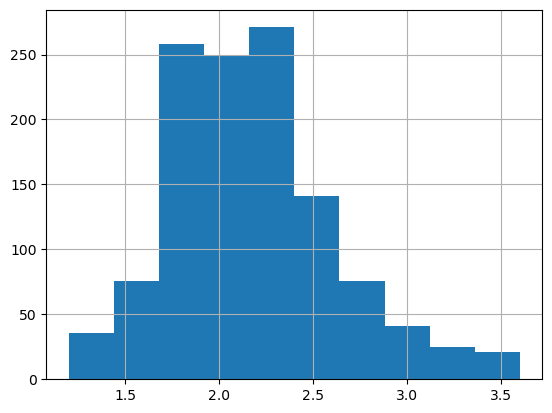

In [76]:
red_wine_filtered["residual_sugar"].hist()

In [77]:
# merge datasets

white_and_red_filtered = pd.merge(red_wine_filtered, white_wine_filtered, how = "outer")

# Encoding
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red_filtered['quality_label_encoded'] = enc.fit_transform(white_and_red_filtered[['quality_label']])

#Feauture / Target split
X_filtered=white_and_red_filtered.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y_filtered= white_and_red_filtered["quality_label_encoded"]


# Train-test split
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

#Smote
smote = SMOTE(random_state=42)
X_train_resampled_filtered, y_train_resampled_filtered = smote.fit_resample(X_train_filtered, y_train_filtered)

## standarization
norm = MinMaxScaler().fit(X_train_resampled_filtered)

# transform training data
X_train_resampled_filtered_norm = norm.transform(X_train_resampled_filtered)

# transform testing data
X_test_resampled_filtered_norm = norm.transform(X_test_filtered)

# define model
RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model

RF_clf.fit(X_train_resampled_filtered_norm, y_train_resampled_filtered)

RF_preds = RF_clf.predict(X_test_resampled_filtered_norm)

RF_acc = accuracy_score(y_test_filtered, RF_preds)
RF_acc

0.7792706333973128

In [78]:
print("White_and_red shape: ", white_and_red.shape)
print("X_filtered: ", X_filtered.shape)
print("X_train_filtered: ", X_train_filtered.shape)

White_and_red shape:  (6497, 15)
X_filtered:  (5209, 11)
X_train_filtered:  (4167, 11)


Random forest- Filtered data set with zscore- smote after split- normalized

In [79]:
## Filtering with z score

# create a copy of the columns(numeric values only) to iterate over ( if not it iterates over the newly created as well)



white_wines_clean= white_wines.drop("quality", axis=1)
numeric_columns = white_wines_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
ww_filtered= white_wines.copy()
z_score_dict = {}
for x in numeric_columns:
    z_score_dict[f'z_score_{x}'] = zscore(white_wines[x])


# Create a DataFrame from the z_score_dict
z_score_df = pd.DataFrame(z_score_dict, index=white_wines.index)

# Concatenate the original DataFrame with the z_score DataFrame

white_wines_with_zscores = pd.concat([ww_filtered, z_score_df], axis=1)

# # Filter rows where the absolute value of all z_scores is less than 3
z_score_columns = z_score_df.columns
filtered_white_wines_z = white_wines_with_zscores[(white_wines_with_zscores[z_score_columns].abs() < 3).all(axis=1)]


red_wines_clean= red_wines.drop("quality", axis=1)
numeric_columns_red = red_wines_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
rw_filtered= red_wines.copy()
z_score_dict_red = {}
for x in numeric_columns_red:
    z_score_dict_red[f'z_score_{x}'] = zscore(red_wines[x])


# Create a DataFrame from the z_score_dict
z_score_df_red = pd.DataFrame(z_score_dict_red, index=red_wines.index)

# Concatenate the original DataFrame with the z_score DataFrame

red_wines_with_zscores = pd.concat([rw_filtered, z_score_df_red], axis=1)

# # Filter rows where the absolute value of all z_scores is less than 3
z_score_columns_red = z_score_df_red.columns
filtered_red_wines_z = red_wines_with_zscores[(red_wines_with_zscores[z_score_columns_red].abs() < 3).all(axis=1)]


In [80]:
# merge datasets
white_and_red_filtered_z = pd.merge(filtered_white_wines_z, filtered_red_wines_z, how = "outer")

# Encoding
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red_filtered_z['quality_label_encoded'] = enc.fit_transform(white_and_red_filtered_z[['quality_label']])

#Feauture / Target split
X_filtered_z=white_and_red_filtered_z.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y_filtered_z= white_and_red_filtered_z["quality_label_encoded"]


# Train-test split
X_train_filtered_z, X_test_filtered_z, y_train_filtered_z, y_test_filtered_z = train_test_split(
    X_filtered_z, y_filtered_z, test_size=0.2, random_state=42)

#Smote
smote = SMOTE(random_state=42)
X_train_resampled_filtered_z, y_train_resampled_filtered_z = smote.fit_resample(X_train_filtered_z, y_train_filtered_z)

## standarization
norm = MinMaxScaler().fit(X_train_resampled_filtered_z)

# transform training data
X_train_resampled_filtered_norm_z = norm.transform(X_train_resampled_filtered_z)

# transform testing data
X_test_resampled_filtered_norm_z = norm.transform(X_test_filtered_z)

# define model
RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model

RF_clf.fit(X_train_resampled_filtered_norm_z, y_train_resampled_filtered_z)

RF_preds = RF_clf.predict(X_test_resampled_filtered_norm_z)

RF_acc = accuracy_score(y_test_filtered_z, RF_preds)
RF_acc

0.7751677852348994

# Random forest- Filtered data set with iqr- (no smote) standarization (robust scaler)


In [81]:
from sklearn.preprocessing import StandardScaler


# copy of datasets
X_train_stand = X_train_filtered.copy()
X_test_stand = X_test_filtered.copy()

scale = StandardScaler().fit(X_train_stand)
    
# transform the training data column
X_train_stand = scale.transform(X_train_stand)
    
# transform the testing data column
X_test_stand = scale.transform(X_test_stand)


# ## standarization
# norm = MinMaxScaler().fit(X_train_resampled_filtered)

# # transform training data
# X_train_resampled_filtered_norm = norm.transform(X_train_resampled_filtered)

# # transform testing data
# X_test_resampled_filtered_norm = norm.transform(X_test_filtered)

# define model
RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model

RF_clf.fit(X_train_stand, y_train_filtered)

RF_preds = RF_clf.predict(X_test_stand)

RF_acc = accuracy_score(y_test_filtered, RF_preds)
RF_acc

0.809021113243762

Random forest- Filtered data set with iqr- smote - standarization (robust scaler)

In [82]:
# copy of datasets
X_train_stand_resampled = X_train_resampled_filtered.copy()
X_test_stand = X_test_filtered.copy()

scale = StandardScaler().fit(X_train_stand_resampled)
    
# transform the training data column
X_train_stand_resampled = scale.transform(X_train_stand_resampled)
    
# transform the testing data column
X_test_stand = scale.transform(X_test_stand)


# ## standarization
# norm = MinMaxScaler().fit(X_train_resampled_filtered)

# # transform training data
# X_train_resampled_filtered_norm = norm.transform(X_train_resampled_filtered)

# # transform testing data
# X_test_resampled_filtered_norm = norm.transform(X_test_filtered)

# define model
RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model

RF_clf.fit(X_train_stand_resampled, y_train_resampled_filtered)

RF_preds = RF_clf.predict(X_test_stand)

RF_acc = accuracy_score(y_test_filtered, RF_preds)
RF_acc

0.7783109404990403

### Random forest with SMOTE (after split) & Stratified K-fold cross validation -normalized

In [83]:
# Apply SMOTE (only on train set)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X_resampled) # normalizes for all X, instead of dividing in train and test.scaling after smote

# Create  classifier object.
# lr = linear_model.LogisticRegression()
rf = RandomForestClassifier(class_weight="balanced")
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_balanced_accuracy_score=[]
lst_kappa= []

# .split generates indices to split data into training and test set.
for train_index, test_index in skf.split(X_resampled,y_resampled):  
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred = rf.predict(x_test_fold)
    kappa = cohen_kappa_score(rf_pred, y_test_fold)
    lst_kappa.append(round(kappa, 4))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, rf_pred)
    lst_balanced_accuracy_score.append(round(balanced_acc_sc,4))
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print('\nMaximum Cohen-Kappa score that can be obtained from this model is:',
      max(lst_kappa)*100, '%')
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_balanced_accuracy_score)*100, '%')



List of possible accuracy: [0.8854961832061069, 0.8676844783715013, 0.8854961832061069, 0.8956743002544529, 0.8955414012738854, 0.8993630573248408, 0.8777070063694268, 0.8929936305732484, 0.8968152866242038, 0.913375796178344]

Maximum Accuracy That can be obtained from this model is: 91.3375796178344 %

Minimum Accuracy: 86.76844783715013 %

Overall Accuracy: 89.10147323382117 %

Standard Deviation is: 0.012612963211940435

Maximum Cohen-Kappa score that can be obtained from this model is: 87.01 %

Maximum Balanced Accuracy That can be obtained from this model is: 91.33 %


In [84]:
# # Classification report
print("Classification Report: Random forest with SMOTE, Normalization & Stratified K-fold cross validation")
print(classification_report(y_test_fold, rf_pred))

Classification Report: Random forest with SMOTE, Normalization & Stratified K-fold cross validation
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       262
         1.0       0.89      0.85      0.87       261
         2.0       0.96      1.00      0.98       262

    accuracy                           0.91       785
   macro avg       0.91      0.91      0.91       785
weighted avg       0.91      0.91      0.91       785



### Random forest with SMOTE (after split) & Stratified K-fold cross validation -standarized

In [85]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

# standarize

scale = preprocessing.StandardScaler()
x_scaled = scale.fit_transform(X_resampled) #  for all X, instead of dividing in train and test.scaling after smote

# Create  classifier object.
rf = RandomForestClassifier(class_weight="balanced")
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_balanced_accuracy_score=[]
lst_kappa= []

# .split generates indices to split data into training and test set.
for train_index, test_index in skf.split(X_resampled,y_resampled):  
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred = rf.predict(x_test_fold)
    kappa = cohen_kappa_score(rf_pred, y_test_fold)
    lst_kappa.append(round(kappa, 4))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, rf_pred)
    lst_balanced_accuracy_score.append(round(balanced_acc_sc,4))
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print('\nMaximum Cohen-Kappa score that can be obtained from this model is:',
      max(lst_kappa)*100, '%')
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_balanced_accuracy_score)*100, '%')


List of possible accuracy: [0.8956743002544529, 0.8727735368956743, 0.8791348600508906, 0.8880407124681934, 0.8993630573248408, 0.8929936305732484, 0.8738853503184714, 0.8866242038216561, 0.9070063694267516, 0.9197452229299363]

Maximum Accuracy That can be obtained from this model is: 91.97452229299363 %

Minimum Accuracy: 87.27735368956743 %

Overall Accuracy: 89.15241244064116 %

Standard Deviation is: 0.01479230552629917

Maximum Cohen-Kappa score that can be obtained from this model is: 87.96000000000001 %

Maximum Balanced Accuracy That can be obtained from this model is: 91.97 %


In [94]:
print("X_resampled shape: ",X_resampled.shape)
print("X_train shape: ", X_train_filtered.shape)

X_resampled shape:  (7854, 11)
X_train shape:  (4167, 11)


In [87]:
# # Classification report
print("Classification Report: Random forest with SMOTE, Standarisation & Stratified K-fold cross validation")
print(classification_report(y_test_fold, rf_pred))

Classification Report: Random forest with SMOTE, Standarisation & Stratified K-fold cross validation
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       262
         1.0       0.90      0.87      0.88       261
         2.0       0.96      1.00      0.98       262

    accuracy                           0.92       785
   macro avg       0.92      0.92      0.92       785
weighted avg       0.92      0.92      0.92       785



### Random forest with SMOTE & Undersampling / standarized / Stratified K-fold cross validation 

In [88]:
model = RandomForestClassifier()
over = SMOTE(random_state=42) # (sampling_strategy=0.1)
under = RandomUnderSampler() #(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)


In [89]:
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

# standarize

scale = preprocessing.StandardScaler()
x_scaled = scale.fit_transform(X_filtered) # normalizes for all X, instead of dividing in train and test.scaling after smote

# Create  classifier object.
# rf = RandomForestClassifier(class_weight="balanced")
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_balanced_accuracy_score=[]
lst_kappa= []

# .split generates indices to split data into training and test set.
for train_index, test_index in skf.split(X_train_filtered,y_train_filtered):  
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y_filtered[train_index], y_filtered[test_index]
    pipeline.fit(x_train_fold, y_train_fold)
    pipeline_pred = pipeline.predict(x_test_fold)
    kappa = cohen_kappa_score(pipeline_pred, y_test_fold)
    lst_kappa.append(round(kappa, 4))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, pipeline_pred)
    lst_balanced_accuracy_score.append(round(balanced_acc_sc,4))
    lst_accu_stratified.append(pipeline.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print('\nMaximum Cohen-Kappa score that can be obtained from this model is:',
      max(lst_kappa)*100, '%')
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_balanced_accuracy_score)*100, '%')

List of possible accuracy: [0.7937649880095923, 0.8081534772182254, 0.7985611510791367, 0.8105515587529976, 0.8393285371702638, 0.8057553956834532, 0.8513189448441247, 0.8341346153846154, 0.8028846153846154, 0.8125]

Maximum Accuracy That can be obtained from this model is: 85.13189448441247 %

Minimum Accuracy: 79.37649880095923 %

Overall Accuracy: 81.56953283527024 %

Standard Deviation is: 0.019144370833007154

Maximum Cohen-Kappa score that can be obtained from this model is: 67.52 %

Maximum Balanced Accuracy That can be obtained from this model is: 74.88 %


# Determine quality per type of wine with random forest

## white wine

In [90]:
# Encoding
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_wine_filtered['quality_label_encoded'] = enc.fit_transform(white_wine_filtered[['quality_label']])

#Feauture / Target split
Xw_filtered=white_wine_filtered.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
yw_filtered= white_wine_filtered["quality_label_encoded"]


# Train-test split
Xw_train_filtered, Xw_test_filtered, yw_train_filtered, yw_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

#Smote
smote = SMOTE(random_state=42)
Xw_train_resampled_filtered, yw_train_resampled_filtered = smote.fit_resample(Xw_train_filtered, yw_train_filtered)

## standarization
norm = MinMaxScaler().fit(Xw_train_resampled_filtered)

# transform training data
Xw_train_resampled_filtered_norm = norm.transform(Xw_train_resampled_filtered)

# transform testing data
Xw_test_resampled_filtered_norm = norm.transform(Xw_test_filtered)

# define model
RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model

RF_clf.fit(Xw_train_resampled_filtered_norm, yw_train_resampled_filtered)

RFw_preds = RF_clf.predict(Xw_test_resampled_filtered_norm)

RFw_acc = accuracy_score(yw_test_filtered, RFw_preds)
RFw_acc

0.7792706333973128

In [91]:
smote = SMOTE(random_state=42)
Xw_resampled, yw_resampled = smote.fit_resample(Xw_train_filtered, yw_train_filtered)

# standarize

scale = preprocessing.StandardScaler()
xw_scaled = scale.fit_transform(Xw_resampled) # standarization for all X, instead of dividing in train and test.scaling after smote

# Create  classifier object.
rf = RandomForestClassifier(class_weight="balanced")
  
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_balanced_accuracy_score=[]
lst_kappa= []

# .split generates indices to split data into training and test set.
for train_index, test_index in skf.split(Xw_resampled,yw_resampled):  
    x_train_fold, x_test_fold = xw_scaled[train_index], xw_scaled[test_index]
    y_train_fold, y_test_fold = yw_resampled[train_index], yw_resampled[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred = rf.predict(x_test_fold)
    kappa = cohen_kappa_score(rf_pred, y_test_fold)
    lst_kappa.append(round(kappa, 4))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, rf_pred)
    lst_balanced_accuracy_score.append(round(balanced_acc_sc,4))
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print('\nMaximum Cohen-Kappa score that can be obtained from this model is:',
      max(lst_kappa)*100, '%')
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_balanced_accuracy_score)*100, '%')

List of possible accuracy: [0.8918575063613231, 0.8676844783715013, 0.8867684478371501, 0.8893129770992366, 0.889171974522293, 0.8853503184713376, 0.8764331210191083, 0.8853503184713376, 0.9019108280254777, 0.9095541401273886]

Maximum Accuracy That can be obtained from this model is: 90.95541401273886 %

Minimum Accuracy: 86.76844783715013 %

Overall Accuracy: 88.83394110306155 %

Standard Deviation is: 0.011723619731660608

Maximum Cohen-Kappa score that can be obtained from this model is: 86.42999999999999 %

Maximum Balanced Accuracy That can be obtained from this model is: 90.95 %


In [92]:
# # Classification report
print("Classification Report: Random forest with SMOTE & Stratified K-fold cross validation")
print(classification_report(y_test_fold, rf_pred))

Classification Report: Random forest with SMOTE & Stratified K-fold cross validation
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       262
         1.0       0.88      0.85      0.86       261
         2.0       0.95      1.00      0.97       262

    accuracy                           0.91       785
   macro avg       0.91      0.91      0.91       785
weighted avg       0.91      0.91      0.91       785



## red wine

In [93]:
# Encoding
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
red_wine_filtered['quality_label_encoded'] = enc.fit_transform(red_wine_filtered[['quality_label']])

#Feauture / Target split
Xr_filtered=red_wine_filtered.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
yr_filtered= red_wine_filtered["quality_label_encoded"]


# Train-test split
Xr_train_filtered, Xr_test_filtered, yr_train_filtered, yr_test_filtered = train_test_split(
    Xr_filtered, yr_filtered, test_size=0.2, random_state=42)

#Smote
smote = SMOTE(random_state=42)
Xr_train_resampled_filtered, yr_train_resampled_filtered = smote.fit_resample(Xr_train_filtered, yr_train_filtered)

## standarization
norm = MinMaxScaler().fit(Xr_train_resampled_filtered)

# transform training data
Xr_train_resampled_filtered_norm = norm.transform(Xr_train_resampled_filtered)

# transform testing data
Xr_test_resampled_filtered_norm = norm.transform(Xr_test_filtered)

# define model
RF_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model

RF_clf.fit(Xr_train_resampled_filtered_norm, yr_train_resampled_filtered)

RFr_preds = RF_clf.predict(Xr_test_resampled_filtered_norm)

RFr_acc = accuracy_score(yr_test_filtered, RFr_preds)
RFr_acc

0.7573221757322176